<a href="https://colab.research.google.com/github/yangmz0528/Cracks_Dectection/blob/main/Crack_Detection_Mingzi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Testing for GPU 


To Test if you have GPU set up

Run the Cell below

if no GPU is found press Runtime (in the menu at the top) and choose "Change Runtime Type" to GPU

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Download Dataset

In [ ]:
!ls

archive  sample_data


In [ ]:
!wget -qq https://www.dropbox.com/s/bpy28t6mgbu96wq/crack_classification.zip
!unzip -qq crack_classification.zip
!rm crack_classification.zip

!ls

replace archive/Negative/00001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: archive  sample_data


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, json
from glob import glob
import numpy as np

import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Model,layers


from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback

In [ ]:
print(tf.__version__)
print(tf.keras.__version__)

2.10.0
2.10.0


In [ ]:
!ls archive

Negative  Positive


## Converting raw files in folders into something we can feed into tf.data
- use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.

- split them up so we have 10% for a testing set and the rest for training and shuffle them up.



In [ ]:
path = "archive"

In [ ]:
import glob
import pandas as pd

filenames_n0 = glob.glob('./archive/Negative/*.jpg')
filenames_n1 = glob.glob('./archive/Positive/*.jpg')


names = ['negative', 'positive']


len(filenames_n1)

20000

In [ ]:
filenames_n1[:10]

['./archive/Positive/12609_1.jpg',
 './archive/Positive/09243.jpg',
 './archive/Positive/02085.jpg',
 './archive/Positive/14435_1.jpg',
 './archive/Positive/03959.jpg',
 './archive/Positive/16788_1.jpg',
 './archive/Positive/11136_1.jpg',
 './archive/Positive/14270_1.jpg',
 './archive/Positive/09681.jpg',
 './archive/Positive/12113_1.jpg']

In [ ]:

# Make a dataframe based on the filenames
df = pd.DataFrame(filenames_n0, columns = ["filename"])
df2 = pd.DataFrame(filenames_n1, columns = ["filename"])


# Add Class columns 
df['class'] = pd.Series([0 for x in range(len(df.index))], index=df.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)



# Split into train and validation sets
train_set_percentage = .9


# Test with 5000 images each first
train_df = df[:int(5000*train_set_percentage)]
val_df = df[int(5000*train_set_percentage):5000]

train_df2 = df2[:int(5000*train_set_percentage)]
val_df2 = df2[int(5000*train_set_percentage):5000]



df_new_train = pd.concat([train_df, train_df2])
df_new_val = pd.concat([val_df, val_df2])

# shuffle 
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

In [ ]:
df.shape, df_val.shape

((9000, 2), (1000, 2))

# Examine the Dataset

look at what we have now. 

In [ ]:
df.head()

,filename,class
0,./archive/Negative/09582.jpg,0
1,./archive/Negative/14528.jpg,0
2,./archive/Negative/09813.jpg,0
3,./archive/Negative/13624.jpg,0
4,./archive/Negative/05625.jpg,0


In [ ]:
print(df.shape)
print(df_val.shape)

df['class'].unique()

(9000, 2)
(1000, 2)


array([0, 1])

0    4500
1    4500
Name: class, dtype: int64


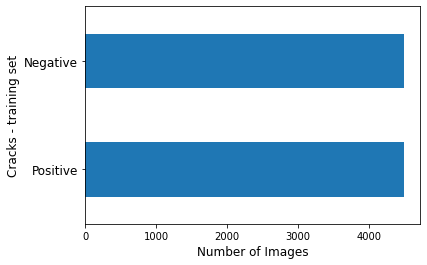

In [ ]:
print(df['class'].value_counts())


ax = df['class'].value_counts().plot.barh()
ax.set_xlabel("Number of Images", fontsize=12)
ax.set_ylabel("Cracks - training set", fontsize=12)
ax.set_yticklabels(['Positive','Negative'], rotation=0, fontsize=12)
plt.show()

In [ ]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 2


## Make the pipeline for loading and resizing the images

In [ ]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 299,299

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [ ]:
# A vector of filenames - from a list
filenames = tf.constant(train_filenames_list)

# Labels that match the training files - from a list
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

## Assembling the Data pipeline using tf.data

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(100)
train_dataset = train_dataset.batch(32)

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(100)
valid_dataset = valid_dataset.batch(32)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.repeat(100)
test_dataset = test_dataset.batch(32)

## Model 1: InceptionV3

Using pre-trained network for Transfer Learning

In [ ]:
# InceptionV3 Model - trained on imagenet
base_model = InceptionV3(weights='imagenet', include_top=False)

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

## Create a simple head for the model that we can train

In [ ]:
# We will use the part of the pre_trained model from input later until the layer 'mixed7'
# You can also choose different layer for starting
last_layer = base_model.get_layer('mixed7') 
last_output = last_layer.output


#Then we add our layers 

#takes a average pooling in a way that flattenning an amount
x = layers.GlobalAveragePooling2D()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout layer to prevent overfitting
#x = layers.Dropout(0.2)(x)  

# Add a final sigmoid layer for classification
x = layers.Dense(num_classes, activation='sigmoid')(x)    

In [ ]:
# this is the model we will train
model = Model(base_model.input, outputs=x)

In [ ]:
model.summary() #the 2 dense layers at the end are not trained

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [ ]:
# Freeze the InceptionV3 layers except the BatchNorm
for layer in base_model.layers:
    if 'batch' in layer.name:
      print(layer.name)
      layer.trainable = True
    else:
      layer.trainable = False 


batch_normalization
batch_normalization_1
batch_normalization_2
batch_normalization_3
batch_normalization_4
batch_normalization_8
batch_normalization_6
batch_normalization_9
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
batch_normalization_15
batch_normalization_13
batch_normalization_16
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
batch_normalization_22
batch_normalization_20
batch_normalization_23
batch_normalization_19
batch_normalization_21
batch_normalization_24
batch_normalization_25
batch_normalization_27
batch_normalization_28
batch_normalization_26
batch_normalization_29
batch_normalization_34
batch_normalization_35
batch_normalization_31
batch_normalization_36
batch_normalization_32
batch_normalization_37
batch_normalization_30
batch_normalization_33
batch_normalization_38
batch_normalization_39
batch_normalization_44
batch_normalization_45
batch_normalization_41
batch_normalization_46


In [ ]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
conv2d
False
batch_normalization
True
activation
False
conv2d_1
False
batch_normalization_1
True
activation_1
False
conv2d_2
False
batch_normalization_2
True
activation_2
False
max_pooling2d
False
conv2d_3
False
batch_normalization_3
True
activation_3
False
conv2d_4
False
batch_normalization_4
True
activation_4
False
max_pooling2d_1
False
conv2d_8
False
batch_normalization_8
True
activation_8
False
conv2d_6
False
conv2d_9
False
batch_normalization_6
True
batch_normalization_9
True
activation_6
False
activation_9
False
average_pooling2d
False
conv2d_5
False
conv2d_7
False
conv2d_10
False
conv2d_11
False
batch_normalization_5
True
batch_normalization_7
True
batch_normalization_10
True
batch_normalization_11
True
activation_5
False
activation_7
False
activation_10
False
activation_11
False
mixed0
False
conv2d_15
False
batch_normalization_15
True
activation_15
False
conv2d_13
False
conv2d_16
False
batch_normalization_13
True
batch_normalization_16
True
activation_13
False
act

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

## Select the optimizer

## Compile the model

In [ ]:
# compile the model 

model.compile(optimizer=RMSprop(0.001), loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
train_steps = int(9000/32) #total trains set / batch_size
val_steps = int(1000/32)
epochs = 1

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 281
val steps: 31


In [ ]:
!mkdir checkpoints


checkpoint = ModelCheckpoint('./checkpoints/weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, save_best_only=True, mode='auto')

mkdir: cannot create directory ‘checkpoints’: File exists


In [ ]:
### Train the model with validation 
history = model.fit( train_dataset, 
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

281/281 [==============================] - 112s 339ms/step - loss: 0.0738 - accuracy: 0.9749 - val_loss: 0.0048 - val_accuracy: 0.9980


In [ ]:
epochs = 4

### Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/4
281/281 [==============================] - 90s 321ms/step - loss: 0.0114 - accuracy: 0.9954 - val_loss: 0.0024 - val_accuracy: 0.9990
Epoch 2/4
281/281 [==============================] - 90s 319ms/step - loss: 0.0099 - accuracy: 0.9969 - val_loss: 0.0026 - val_accuracy: 0.9990
Epoch 3/4
281/281 [==============================] - 90s 320ms/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 4/4
281/281 [==============================] - 90s 319ms/step - loss: 0.0054 - accuracy: 0.9981 - val_loss: 7.6662e-04 - val_accuracy: 1.0000


In [ ]:
!ls checkpoints

In [ ]:
model.load_weights('./checkpoints/weights_02_0.91.hdf5')

OSError: ignored

In [ ]:
metrics = model.evaluate(valid_dataset,steps=50)
print("model accuracy:",metrics[1])

50/50 [==============================] - 7s 144ms/step - loss: 5.9073e-04 - accuracy: 1.0000
model accuracy: 1.0


## Make Confusion Matrix

In [ ]:
preds = model.predict(test_dataset,steps=10)
preds = preds.argmax(axis=-1)


10/10 [==============================] - 2s 131ms/step


In [ ]:
test_labels = val_labels_list[0:320]

In [ ]:
len(test_labels)

320

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(test_labels,preds)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


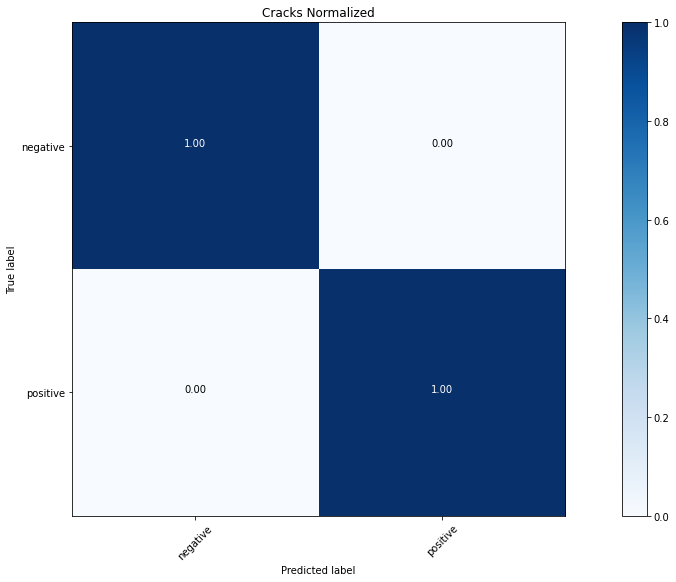

In [ ]:
cm_plot_labels = names

# # Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                      title='Cracks Normalized')

plt.show()